
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Авторы материала: Ольга Дайховская (@aiho в Slack ODS), Юрий Кашницкий (@yorko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 7 (демо)
## <center> Обучение без учителя: метод главных компонент и кластеризация

В этом задании мы разберемся с тем, как работают методы снижения размерности и кластеризации данных. Заодно еще раз попрактикуемся в задаче классификации.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации. 

Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1qzcrfsNFy-e4TW59v2fqMj_OTom2SIOxtq4MWlI92p0).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [3]:
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [3]:
X = np.concatenate([X_train, X_test])
y = np.concatenate([y_train, y_test])

In [4]:
df = pd.DataFrame(X)

In [5]:
df.describe()

0             1             2             3             4    \
count  10299.000000  10299.000000  10299.000000  10299.000000  10299.000000   
mean       0.274347     -0.017743     -0.108925     -0.607784     -0.510191   
std        0.067628      0.037128      0.053033      0.438694      0.500240   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%        0.262625     -0.024902     -0.121019     -0.992360     -0.976990   
50%        0.277174     -0.017162     -0.108596     -0.943030     -0.835032   
75%        0.288354     -0.010625     -0.097589     -0.250293     -0.057336   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                5             6             7             8             9    \
count  10299.000000  10299.000000  10299.000000  10299.000000  10299.000000   
mean      -0.613064     -0.633593     -0.525697     -0.614989     -0.466732   
std        0.403657      0.413333      0.484201      0.399034      0.538707   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.979137     -0.993293     -0.977017     -0.979064     -0.935788   
50%       -0.850773     -0.948244     -0.843670     -0.845068     -0.874825   
75%       -0.278737     -0.302033     -0.087405     -0.288149     -0.014641   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       ...           551           552           553           554  \
count  ...  10299.000000  10299.000000  10299.000000  10299.000000   
mean   ...      0.126708     -0.298592     -0.617700      0.007705   
std    ...      0.245443      0.320199      0.308796      0.336591   
min    ...     -1.000000     -1.000000     -1.000000     -1.000000   
25%    ...     -0.019481     -0.536174     -0.841847     -0.124694   
50%    ...      0.136245     -0.335160     -0.703402      0.008146   
75%    ...      0.288960     -0.113167     -0.487981      0.149005   
max    ...      1.000000      1.000000      1.000000      1.000000   

                555           556           557           558           559  \
count  10299.000000  10299.000000  10299.000000  10299.000000  10299.000000   
mean       0.002648      0.017683     -0.009219     -0.496522      0.063255   
std        0.447364      0.616188      0.484770      0.511158      0.305468   
min       -1.000000     -1.000000     -1.000000     -1.000000     -1.000000   
25%       -0.287031     -0.493108     -0.389041     -0.817288      0.002151   
50%        0.007668      0.017192     -0.007186     -0.715631      0.182028   
75%        0.291490      0.536137      0.365996     -0.521503      0.250790   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

                560  
count  10299.000000  
mean      -0.054284  
std        0.268898  
min       -1.000000  
25%       -0.131880  
50%       -0.003882  
75%        0.102970  
max        1.000000  

[8 rows x 561 columns]

Определим число уникальных значений меток целевого класса.

In [6]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [7]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбе
- 2 - подъему вверх по лестнице
- 3 - спуску по лестнице
- 4 - сидению
- 5 - стоянию
- 6 - лежанию

*уж простите, если звучание этих существительных кажется корявым :)*

Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
df_scaled = pd.DataFrame(X_scaled)
df_scaled.describe()

0             1             2             3             4    \
count  1.029900e+04  1.029900e+04  1.029900e+04  1.029900e+04  1.029900e+04   
mean   5.528413e-15 -1.386514e-15 -5.283374e-15 -2.213364e-15  4.638272e-16   
std    1.000049e+00  1.000049e+00  1.000049e+00  1.000049e+00  1.000049e+00   
min   -1.884446e+01 -2.645712e+01 -1.680306e+01 -8.940979e-01 -9.791952e-01   
25%   -1.733464e-01 -1.928276e-01 -2.280545e-01 -8.766828e-01 -9.331955e-01   
50%    4.179874e-02  1.567263e-02  6.196673e-03 -7.642289e-01 -6.494012e-01   
75%    2.071285e-01  1.917487e-01  2.137578e-01  8.149381e-01  9.053215e-01   
max    1.073062e+01  2.741296e+01  2.091108e+01  3.665112e+00  3.019082e+00   

                5             6             7             8             9    \
count  1.029900e+04  1.029900e+04  1.029900e+04  1.029900e+04  1.029900e+04   
mean  -3.317000e-15 -2.630514e-16  2.033566e-15  4.484217e-15  3.594680e-15   
std    1.000049e+00  1.000049e+00  1.000049e+00  1.000049e+00  1.000049e+00   
min   -9.586230e-01 -8.865132e-01 -9.796073e-01 -9.649046e-01 -9.899514e-01   
25%   -9.069353e-01 -8.702863e-01 -9.321383e-01 -9.124348e-01 -8.707498e-01   
50%   -5.889169e-01 -7.612904e-01 -6.567302e-01 -5.766190e-01 -7.575773e-01   
75%    8.282862e-01  8.022011e-01  9.052307e-01  8.191174e-01  8.392575e-01   
max    3.996324e+00  3.952435e+00  3.151112e+00  4.047442e+00  2.722824e+00   

       ...           551           552           553           554  \
count  ...  1.029900e+04  1.029900e+04  1.029900e+04  1.029900e+04   
mean   ... -8.390544e-16  3.587447e-16 -6.495274e-15 -3.169294e-18   
std    ...  1.000049e+00  1.000049e+00  1.000049e+00  1.000049e+00   
min    ... -4.590729e+00 -2.190647e+00 -1.238096e+00 -2.994001e+00   
25%    ... -5.956399e-01 -7.420207e-01 -7.259118e-01 -3.933718e-01   
50%    ...  3.885929e-02 -1.142092e-01 -2.775500e-01  1.308521e-03   
75%    ...  6.610901e-01  5.791199e-01  4.201015e-01  4.198185e-01   
max    ...  3.558197e+00  4.055778e+00  5.238996e+00  2.948216e+00   

                555           556           557           558           559  \
count  1.029900e+04  1.029900e+04  1.029900e+04  1.029900e+04  1.029900e+04   
mean   3.780515e-17  1.177382e-16 -1.641511e-17  1.007587e-15  6.350769e-16   
std    1.000049e+00  1.000049e+00  1.000049e+00  1.000049e+00  1.000049e+00   
min   -2.241345e+00 -1.651658e+00 -2.043916e+00 -9.850233e-01 -3.480911e+00   
25%   -6.475544e-01 -8.289932e-01 -7.835475e-01 -6.275580e-01 -2.000444e-01   
50%    1.122157e-02 -7.966215e-04  4.193739e-03 -4.286737e-01  3.888429e-01   
75%    6.456863e-01  8.414289e-01  7.740442e-01 -4.887380e-02  6.139570e-01   
max    2.229507e+00  1.594260e+00  2.081953e+00  2.927853e+00  3.066738e+00   

                560  
count  1.029900e+04  
mean   4.411140e-17  
std    1.000049e+00  
min   -3.517174e+00  
25%   -2.885829e-01  
50%    1.874505e-01  
75%    5.848385e-01  
max    3.920947e+00  

[8 rows x 561 columns]

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [10]:
pca = PCA(0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [16]:
pca.explained_variance_ratio_.size

65

**Варианты:**
- 56 
- 65
- 66
- 193

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов. 

**Варианты:**
- 45
- 51
- 56
- 61

In [19]:
round(pca.explained_variance_ratio_[0]*100)

51

Визуализируйте данные в проекции на первые две главные компоненты.

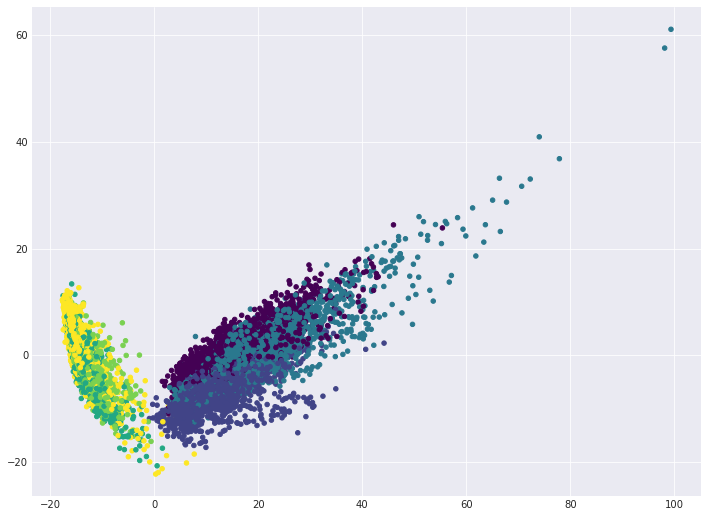

In [25]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='viridis');

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
- 1 кластер: все 6 активностей
- 2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 3 кластера: (ходьба), (подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)
- 6 кластеров

2

------------------------------

Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае мы подскажем, что нужно искать именно 6 кластеров, но в общем случае мы не будем знать, сколько кластеров надо искать.

Параметры:

- **n_clusters** = n_classes (число уникальных меток целевого класса)
- **n_init** = 100
- **random_state** = RANDOM_STATE (для воспроизводимости результата)

Остальные параметры со значениями по умолчанию.

In [11]:
km = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE).fit(X_pca)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

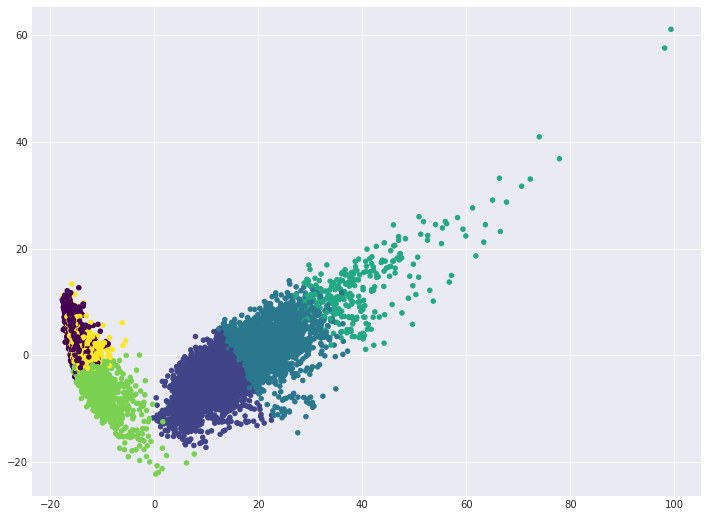

In [13]:
cluster_labels = km.labels_
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,  cmap='viridis');

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [14]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

cluster1  cluster2  cluster3  cluster4  cluster5  \
ходьба                           0       904       740        78         0   
подъем вверх по лестнице         0      1242       295         5         2   
спуск по лестнице                0       320       890       196         0   
сидение                         91         1         0         0       450   
стояние                          0         0         0         0       562   
лежание                       1558         5         0         0       329   
все                           1649      2472      1925       279      1343   

                          cluster6    все  
ходьба                           0   1722  
подъем вверх по лестнице         0   1544  
спуск по лестнице                0   1406  
сидение                       1235   1777  
стояние                       1344   1906  
лежание                         52   1944  
все                           2631  10299

Видим, что каждому классу (т.е. каждой активности) соответствуют несколько кластеров. Давайте посмотрим на максимальную долю объектов в классе, отнесенных к какому-то одному кластеру. Это будет простой метрикой, характеризующей, насколько легко класс отделяется от других при кластеризации. 

Пример: если для класса "спуск по лестнице", в котором 1406 объектов,  распределение кластеров такое:
 - кластер 1 – 900
 - кластер 3 – 500
 - кластер 6 – 6,
 
то такая доля будет 900 / 1406 $\approx$ 0.64.
 

**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- ходьба
- стояние
- спуск по лестнице
- перечисленные варианты не подходят

In [36]:
tab.iloc[:-1, :-1].max(axis=1) / tab.iloc[:-1, -1]

ходьба                      0.524971
подъем вверх по лестнице    0.804404
спуск по лестнице           0.633001
сидение                     0.694992
стояние                     0.705142
лежание                     0.801440
dtype: float64

вверх по лестнице и лежание по 80%

Видно, что kMeans не очень хорошо отличает только активности друг от друга. Используйте метод локтя, чтобы выбрать оптимальное количество кластеров. Параметры алгоритма и данные используем те же, что раньше, меняем только `n_clusters`.

In [15]:
inertia = []
arr = range(1, n_classes+1)

for k in arr:
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
    inertia.append(np.sqrt(kmeans.inertia_))

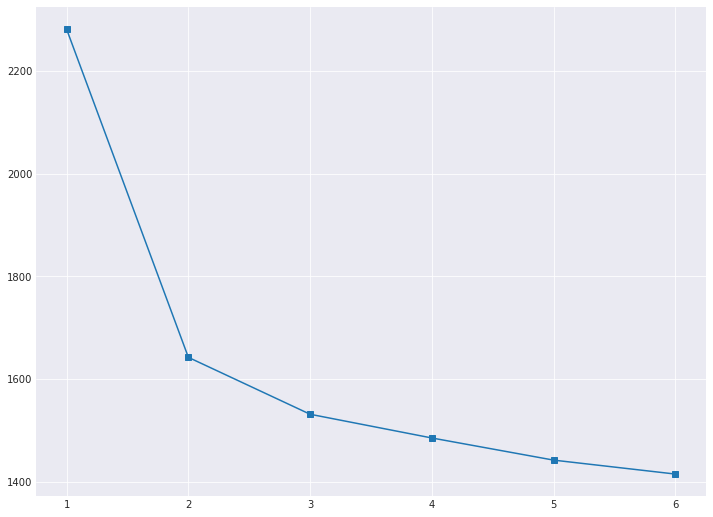

In [41]:
plt.plot(arr, inertia, marker='s');

**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 1
- 2
- 3
- 4

In [28]:
d = {}

for k in range(1, n_classes-1):
    d[k] = abs(inertia[k] - inertia[k+1]) / abs(inertia[k-1] - inertia[k])
    
d

{1: 0.17344753560094545,
 2: 0.41688085835855,
 3: 0.9332338098716374,
 4: 0.6296978665437634}

выбирается следующее значение после минимального, то есть когда спуск замедляется. это 2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [42]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)
metrics.adjusted_rand_score(y, ag.labels_)

0.49362763373004886

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [43]:
metrics.adjusted_rand_score(y, km.labels_)

0.4199036333641994

**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Варианты:**
- Согласно ARI, KMeans справился с кластеризацией хуже, чем Agglomerative Clustering
- Для ARI не имеет значения какие именно метки присвоены кластерам, имеет значение только разбиение объектов на кластеры
- В случае случайного разбиения на кластеры ARI будет близок к нулю

все варианты

-------------------------------

Можно заметить, что задача не очень хорошо решается именно как задача кластеризации, если выделять несколько кластеров (> 2). Давайте теперь решим задачу классификации, вспомнив, что данные у нас размечены.  

Для классификации используйте метод опорных векторов – класс `sklearn.svm.LinearSVC`. Мы в курсе отдельно не рассматривали этот алгоритм, но он очень известен, почитать про него можно, например, в материалах Евгения Соколова –  [тут](https://github.com/esokolov/ml-course-msu/blob/master/ML16/lecture-notes/Sem11_linear.pdf). 

Настройте для `LinearSVC` гиперпараметр `C` с помощью `GridSearchCV`. 

- Обучите новый `StandardScaler` на обучающей выборке (со всеми исходными признаками), прмиените масштабирование к тестовой выборке
- В `GridSearchCV` укажите  cv=3.

In [49]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
svc = LinearSVC(random_state=RANDOM_STATE, max_iter=7000)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [70]:
%%time
grid = GridSearchCV(svc, svc_params, cv=3, n_jobs=-1).fit(X_train_scaled, y_train)
best_svc = grid.best_estimator_

CPU times: user 9.36 s, sys: 64.3 ms, total: 9.42 s
Wall time: 1min 12s


In [65]:
grid.best_params_, grid.best_score_

({'C': 0.1}, 0.9382506099134881)

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

**Ответ:**
- 0.001
- 0.01
- 0.1
- 1
- 10

3

In [58]:
y_predicted = best_svc.predict(X_test_scaled)

In [60]:
tab = pd.crosstab(y_predicted, y_test, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

ходьба  подъем вверх по лестнице  спуск по лестнице  \
ходьба                       494                        12                  2   
подъем вверх по лестнице       2                       459                  4   
спуск по лестнице              0                         0                413   
сидение                        0                         0                  1   
стояние                        0                         0                  0   
лежание                        0                         0                  0   
все                          496                       471                420   

                          сидение  стояние  лежание   все  
ходьба                          0        0        0   508  
подъем вверх по лестнице        4        0        0   469  
спуск по лестнице               0        0        0   413  
сидение                       426       15        0   442  
стояние                        61      517       11   589  
лежание                         0        0      526   526  
все                           491      532      537  2947

**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:**
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – стояние, по полноте – сидение 

4

In [64]:
metrics = pd.DataFrame(index=tab.index[:-1], columns=['precision', 'recall'])

for x in range(n_classes):
    metrics.iloc[x, 0] = tab.iloc[x, x] / tab.iloc[x, n_classes]
    metrics.iloc[x, 1] = tab.iloc[x, x] / tab.iloc[n_classes, x]

metrics

precision    recall
ходьба                    0.972441  0.995968
подъем вверх по лестнице  0.978678  0.974522
спуск по лестнице              1.0  0.983333
сидение                   0.963801  0.867617
стояние                   0.877759  0.971805
лежание                        1.0  0.979516

Наконец, проделайте то же самое, что в 7 вопросе, только добавив PCA.

- Используйте выборки `X_train_scaled` и `X_test_scaled`
- Обучите тот же PCA, что раньше, на отмасшабированной обучающей выборке, примените преобразование к тестовой
- Настройте гиперпараметр `C` на кросс-валидации по обучающей выборке с PCA-преобразованием. Вы заметите, насколько это проходит быстрее, чем раньше.

**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Варианты:**
- Качество одинаковое
- 2%
- 4% 
- 10%
- 20%


3

In [71]:
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [72]:
%%time
grid = grid.fit(X_train_pca, y_train)
best_svc_pca = grid.best_estimator_
grid.best_params_, grid.best_score_

CPU times: user 5.84 s, sys: 29 ms, total: 5.87 s
Wall time: 30.6 s


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


({'C': 0.1}, 0.8983982658750974)

In [74]:
round(100 * abs(best_svc.score(X_test_scaled, y_test) - 
                best_svc_pca.score(X_test_pca, y_test)))

4

**Вопрос 10:**<br>
Выберите все верные утверждения:

**Варианты:**
- Метод главных компонент в данном случае позволил уменьшить время обучения модели, при этом качество (доля верных ответов на кросс-валидации) очень пострадало, более чем на 10%
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком

2 и 3